# Attempt to DataClean - Claude

In [1]:
#import required modules:
import numpy as np
import pandas as pd
from datetime import datetime, timezone
import matplotlib.pyplot as plt


#for the "heavy" work:
from dateutil.parser import parse
import matplotlib as mpl
from matplotlib.pylab import rcParams

import seaborn as sns
#import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf

#from statsmodels.tsa.arima_model import ARIMA

In [2]:
df_aegeri = pd.read_csv("./data/output/geneva_matchup_skin_meteo.csv")
df_aegeri.rename(columns={"skin_datetime": "datetime"}, inplace=True)
df_aegeri.head()

,x,y,y1,y4,air_temp,rel_humidity,sol_irr,wind_speed,rainfall,air_pressure,meteo_timestamp,datetime,meteo_datetime
0,1652652000,16.07,NaN,1,19.628333,62.801667,0.001000,5.474750,0.0,974.000000,1.652652e+09,2022-05-16 00:00:00,2022-05-16 00:00:00
1,1652652300,16.22,NaN,1,19.628333,62.801667,0.001000,5.474750,0.0,974.000000,1.652652e+09,2022-05-16 00:05:00,2022-05-16 00:00:00
2,1652652600,16.12,NaN,1,19.522500,63.103333,0.001000,4.918250,0.0,974.000000,1.652653e+09,2022-05-16 00:10:00,2022-05-16 00:10:00
3,1652652900,16.12,NaN,1,19.522500,63.103333,0.001000,4.918250,0.0,974.000000,1.652653e+09,2022-05-16 00:15:00,2022-05-16 00:10:00
4,1652653200,15.48,NaN,1,19.482500,62.904167,0.001083,4.430667,0.0,974.083333,1.652653e+09,2022-05-16 00:20:00,2022-05-16 00:20:00


In [3]:
df_aegeri["datetime"]=pd.to_datetime(df_aegeri["datetime"])

## 1.1 plot the data

In [4]:
df_aegeri.index=df_aegeri["datetime"]

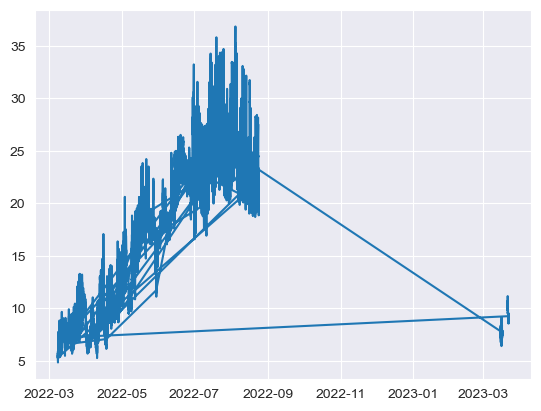

In [5]:
plt.plot(df_aegeri["y"])

### Good, the csv loaded correctly: Now to reduplicate all the following stept, I think it is the best if we make a Class in order to throw all the generated csv at. It is important that the structure of the csv is not changing.

In [6]:
class Data:
    def __init__(self,path,name):
        self.path=path
        self.name=name
        self.dataframe=pd.read_csv(path)
        self.columns=self.dataframe.columns
        #convert the strings and add the datetime column to index
        self.dataframe["datetime"]=pd.to_datetime(self.dataframe["datetime"])
        self.dataframe.index=self.dataframe["x"]
        self.dataframe=self.dataframe.drop(columns=["x"])


    def __repr__(self):
        return f"DataFrame {name} with columns: {str(list(self.columns))}"

    def calc_rolling_statistics(self,column,window,statistics,plot="no",save_plot="no"):
        mean_rm = self.dataframe[column].rolling(window=window).mean()
        std_rm = self.dataframe[column].rolling(window=window).std()


        if print != "no":
            plt.style.context
            plt.figure(figsize=(20,10))
            actual=plt.plot(self.dataframe["datetime"],self.dataframe[column], color='red', label='Actual',alpha=0.7)
            mean_rm=plt.plot(self.dataframe["datetime"],mean_rm, color='green', label=f'Rolling Mean (window: {window})',alpha=0.7)
            std_rm=plt.plot(self.dataframe["datetime"],std_rm, color='black', label=f'Rolling Std (window: {window})',alpha=0.7)
            plt.legend(loc='best')
            plt.title('Rolling Mean & Standard Deviation')
            if save_plot =="yes":
                plt.savefig(f"./data/output_png/{input('How should the figure be named? (no Spaces!)')}.png")
            elif save_plot != "no":
                plt.savefig(f"./data/output_png/{save_plot}.png")

            plt.show(block=False)

    def check_stationarity(self,column):
        print(f"Visual check is advised with {self.name}.calc_rolling_statsitics(...,plot='Y')")
        print("->  A stationary Time Series is one which characteristics like mean and variance does not change over time.")
        self.dataframe[column].hist()
        print("Another way of checking for stationarity of the time series is using Augmented Dickey-Fuller (ADF) Test to check stationarity:")
        print("--------------------")
        print('Dickey-Fuller Test: ')
        X = self.dataframe[column].dropna().values
        dftest=adfuller(X, autolag='AIC')
        dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value

        if list(dfoutput.items())[1][1] > 0.05:
            print(f"with a p-value of {round(list(dfoutput.items())[1][1],3)}, we fail to reject the null hypothesis, that the data is stationary.")
            print(dfoutput)
            return False
        else:
            print(f"with a p-value of {round(list(dfoutput.items())[1][1],3)}, we reject the null hypothesis, that the data is stationary.")
            print(dfoutput)
            return True


    def AutoRegressiveModel(self,column): #source/idea: https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c
        print("The Auto-Regressive (AR) model assumes that the current value (y_t) is dependent on previous values (y_(t-1), y_(t-2), …). Because of this assumption, we can build a linear regression model.\nTo figure out the order of an AR model, you need to look at the PACF:\n------------------------------------------------------------------------------")

        lag_pacf=pacf(self.dataframe[column], nlags=10, method='ols')

        plt.subplot()
        plt.plot(self.dataframe["datetime"],lag_pacf)
        plt.axhline(y=0,linestyle='--',color='green')
        plt.axhline(y=-1.96/np.sqrt(len(self.dataframe[column])),linestyle='--',color='green')
        plt.axhline(y=1.96/np.sqrt(len(self.dataframe[column])),linestyle='--',color='green')
        plt.title('Partial Autocorrelation Function')

    def AutocorrelationModel(self,column):
        plot_acf(self.dataframe[column],lags=10)


    def activate_testingmodus(self):
        self.dataframe=self.dataframe[1:100]

    def detect_outlier(self,column):
        print("DETECT_OUTLIERS(): Any observations that are more than 1.5 IQR below Q1 or more than 1.5 IQR above Q3 are considered outliers. (source: University of Pennsylvania) ")

        if column=="all":
            sns.boxplot(data=self.dataframe)
            plt.title("Boxplot of the whole dataset")
            plt.show()
        else:
            sns.boxplot(data=self.dataframe[["datetime",column]])
            plt.title(f"Boxplot of the column {column}")
            plt.xlabel(f"{column}")
            plt.show()

            q1=self.dataframe[column].quantile(0.25)
            q3=self.dataframe[column].quantile(0.75)
            IQR=q3-q1
            outliers=self.dataframe[["datetime",column]][((self.dataframe[column]<(q1-1.5*IQR)) | (self.dataframe[column]>(q3+1.5*IQR)))]
            plt.plot(self.dataframe["datetime"],self.dataframe[column],label=f"{column}",alpha=0.2) #here, there is an error?? why?
            plt.plot(outliers["datetime"],outliers[column],marker=".",linestyle="",label="outliers")
            plt.legend(loc='best')
            plt.title(f"Outliers in {column}")
            plt.show()


########################################################################################################################
            #HIER WEITERMACHEN

            input_=input(f"Do you want the outliers of {column} returned as a DataFrame [Option 1], or do you want the Outlier-cleaned Dataframe [Option 2]. For Option 1, type '1', for Option 2, type '2'.")
            if input_ == "1":
                return outliers
            elif input_ == "2":
                cleaned=self.dataframe[["datetime",column]]
                cond = self.dataframe[column].isin(outliers)
                cleaned.drop(cleaned[cond].index, inplace = True)
                print("--------------------------------------------------------------")
                print(f"% of outliers:{round(((len(outliers)/len(cleaned))*100),2)}% of {len(self.dataframe[column])} observations")
                print("--------------------------------------------------------------")
                plt.plot(cleaned["datetime"],cleaned[column])
                plt.title(f"cleaned Dataframe from {column}")
                plt.show()
                path="./data/output/cleaned.csv"
                cleaned.to_csv(path)
                return Data(path,"cleaned")


    def detect_outlier2(self,column):
        from statsmodels.tsa.seasonal import seasonal_decompose
        import matplotlib.dates as mdates
        plt.rc('figure',figsize=(12,8))
        plt.rc('font',size=15)
        result = seasonal_decompose(self.dataframe[column],model='additive')
        fig = result.plot()

    def outlier_physical(self): #damian
        self.dataframe.describe()
        #column y1,y2:
        dataframe_filtered=self.dataframe[["datetime","y","y1"]]
        dataframe_filtered.head()
        return dataframe_filtered.head()

In [7]:
path="./data/df_geneve_skin.csv"
name="LakeAegeri"

In [8]:
LakeAegeri=Data(path,name)
#LakeAegeri.dataframe.describe()
#LakeAegeri.activate_testingmodus() #for testing of the code

In [9]:
LakeAegeri.outlier_physical()

,datetime,y,y1
x,,,
1646708700,2022-03-08 04:05:00,5.30,NaN
1646709000,2022-03-08 04:10:00,5.59,NaN
1646709300,2022-03-08 04:15:00,5.49,NaN
1646709600,2022-03-08 04:20:00,5.54,NaN
1646709900,2022-03-08 04:25:00,5.51,NaN


In [10]:
#LakeAegeri.AutoRegressiveModel(column="y")

DETECT_OUTLIERS(): Any observations that are more than 1.5 IQR below Q1 or more than 1.5 IQR above Q3 are considered outliers. (source: University of Pennsylvania) 


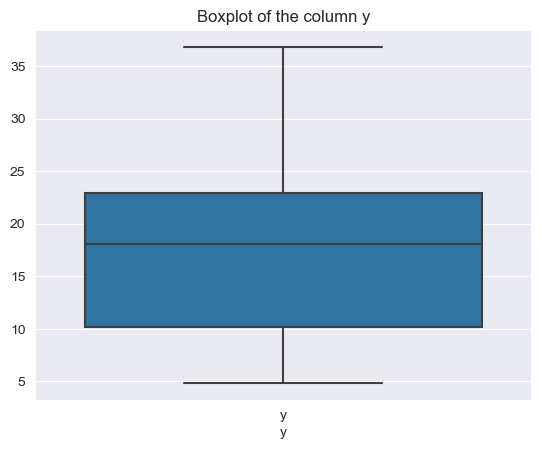

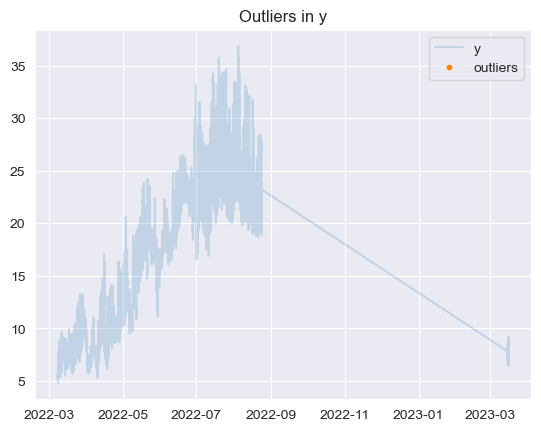

C:\Users\claud\AppData\Local\Temp\ipykernel_10944\1363945138.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned.drop(cleaned[cond].index, inplace = True)


--------------------------------------------------------------
% of outliers:0.0% of 49044 observations
--------------------------------------------------------------


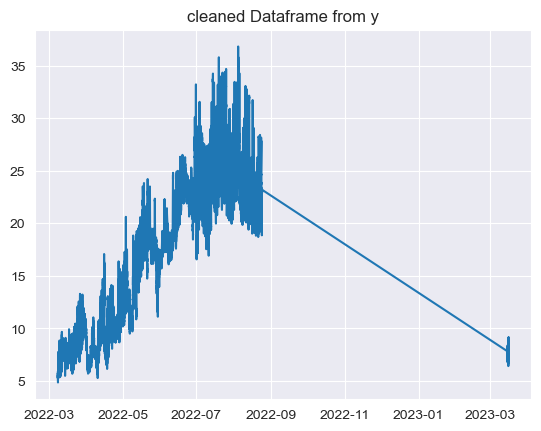

DataFrame LakeAegeri with columns: ['x', 'datetime', 'y']

In [11]:
LakeAegeri.detect_outlier("y")

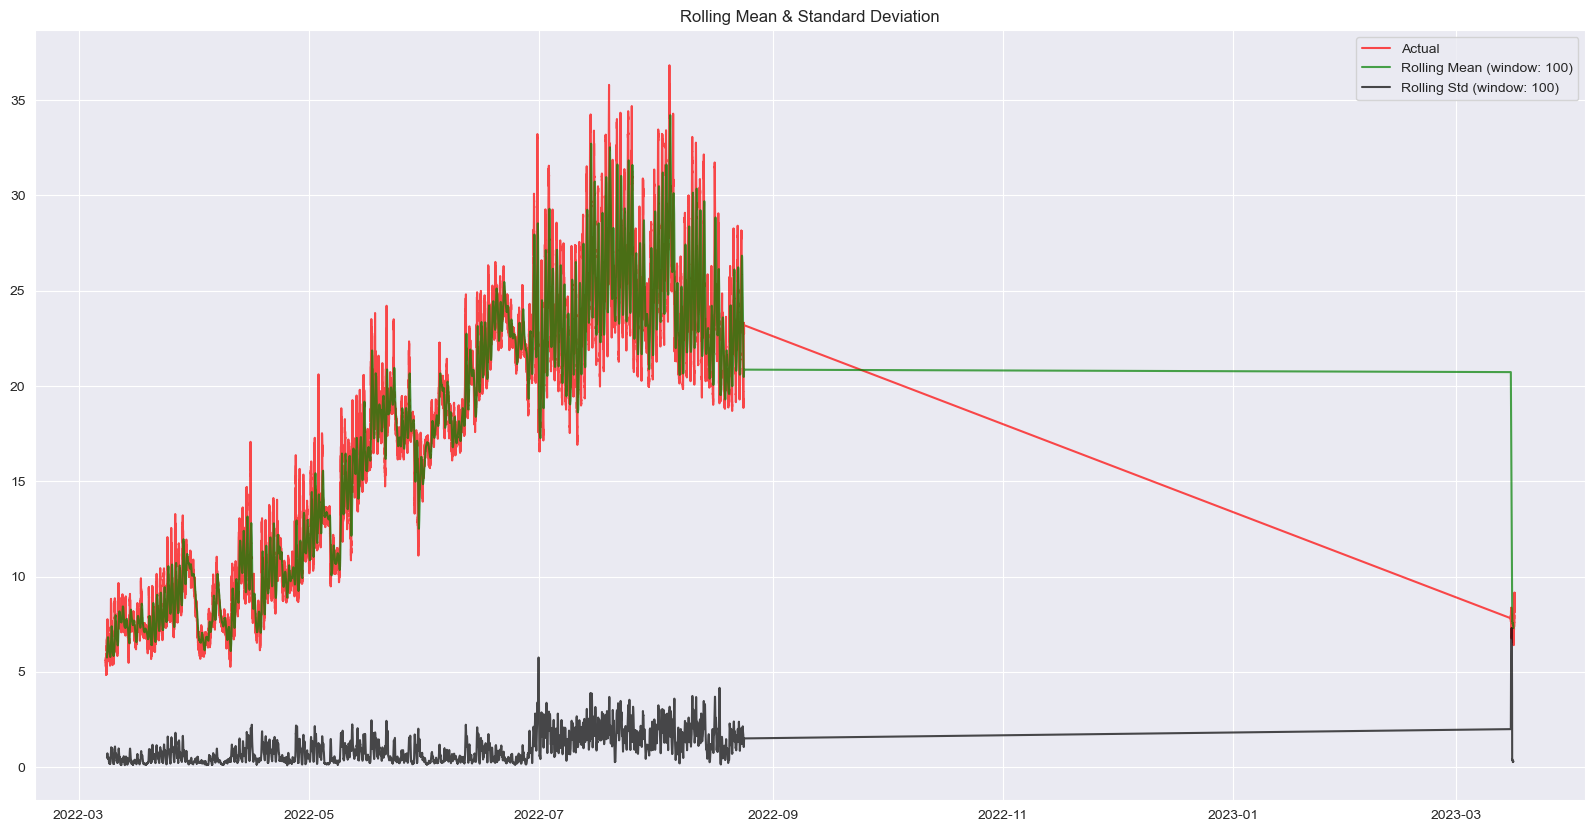

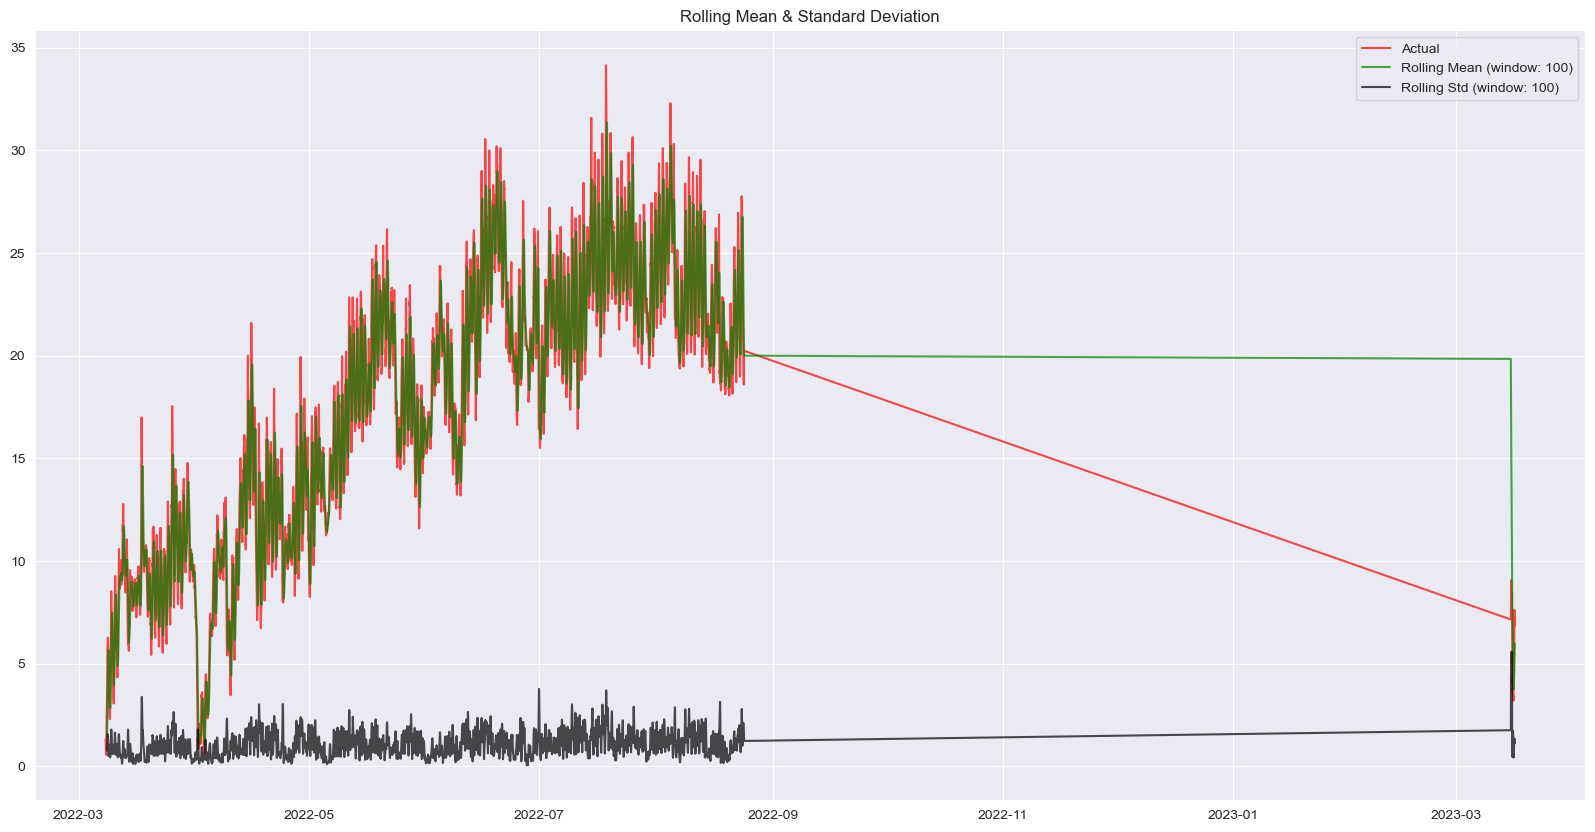

In [12]:
LakeAegeri.calc_rolling_statistics(window=100,column="y",statistics="mean",plot="no",save_plot="rolling_mean")
LakeAegeri.calc_rolling_statistics(window=100,column="air_temp",statistics="mean",plot="no")

DETECT_OUTLIERS(): Any observations that are more than 1.5 IQR below Q1 or more than 1.5 IQR above Q3 are considered outliers. (source: University of Pennsylvania) 


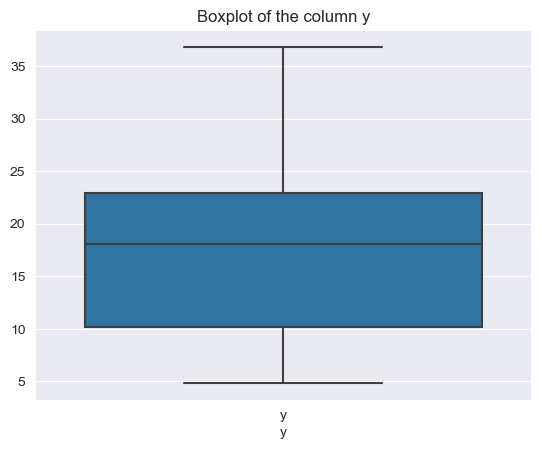

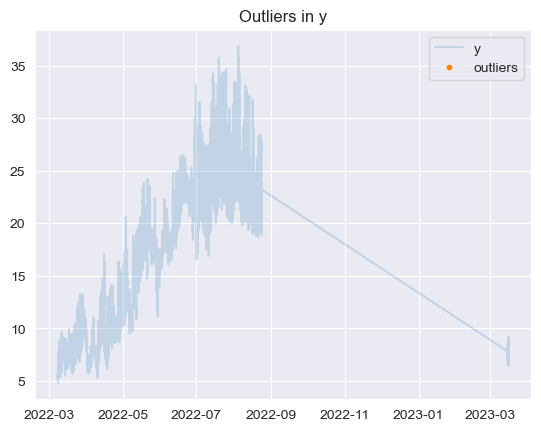

C:\Users\claud\AppData\Local\Temp\ipykernel_10944\1363945138.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned.drop(cleaned[cond].index, inplace = True)


--------------------------------------------------------------
% of outliers:0.0% of 49044 observations
--------------------------------------------------------------


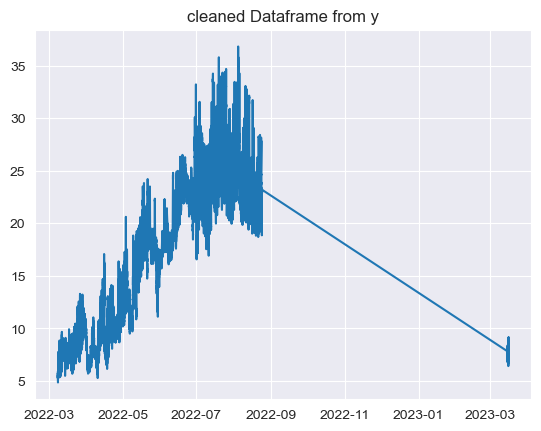

ValueError: This function does not handle missing values

In [13]:
LakeAegeri_noNAN = LakeAegeri.detect_outlier("y")

LakeAegeri_noNAN.detect_outlier2("y")

In [ ]:
LakeAegeri.check_stationarity(column="y")

In [ ]:
print(LakeAegeri.outlier_physical())
LakeAegeri.dataframe[["y","y1","datetime"]].head()s